# libs

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from pycaret.classification import *

# product metric

- **продукт**: чат-бот для психологической поддержки
- **задача ML**: многоклассовая классификация
- **целевая переменная**: метки эмоций
- **бизнесовая метрика**: выдвигаем гипотезу, что на RR влияет процент "хороших" эмоций к концу диалога с ботом относительно начала диалога
- **ML-метрики**: средние F-мера, AUC-ROC

**Подробнее:**

В качестве модели за основу возьмем модель BLOOMZ, с которой будем работать через библиотеку Petals. В данной библиотеке есть метод inference session который позволяет общаться с моделью имитируя общение с человеком. Пример: [https://colab.research.google.com/drive/1Ervk6HPNS6AYVr3xVdQnY5a-TjjmLCdQ#scrollTo=fZlzYVn0ApyF](https://colab.research.google.com/drive/1Ervk6HPNS6AYVr3xVdQnY5a-TjjmLCdQ#scrollTo=fZlzYVn0ApyF)

Дополнительно надо добавить обработку моделью классификации, которая будет определять, в каком настроении человек, ведущий диалог с ботом. В будущем можно проводить дообучение модели на основе эмоций, которые показывали люди в текстовом виде после ответов модели.

MVP: тг-чат, который выдает ответы модели BLOOMZ + модель классификации (лучшая из autoML по F-мере и AUC-ROC), которая определяет настроение в каждой реплике человека, и сохраняет информацию по каждому юзеру в sqllite базу данных.

Термин “улучшение настроения”.
Любой разговор (коммуникация, перерывы в которой не превышают 1 час) будем делить на 4 равные части из сообщений, по первой замерять преобладающее настроение человека в момент обращения к боту, а по последней - настроение после диалога с ботом. Если процент "хороших" эмоций повышается, то значит что бот помогает справляться с тяжелым состоянием, и ожидается, что такие люди будут с большей вероятностью возвращаться к использованию продукта. 

POC: выдвигаем гипотезу, что на RR влияет “улучшение настроения”. Если в конце эксперимента пользователи с “улучшением настроения” будут иметь более высокий RR, то гипотеза подтверждена и имеет смысл дообучить модель на основе классифицированных эмоций, таким образом повысив будущее использование данного сервиса.

# data

labels:
 - 0 > sadness
 - 1 > joy
 - 2 > love
 - 3 > anger
 - 4 > fear
 - 5 > surprise

In [2]:
df_train = pd.read_csv('data/training.csv')
df_test = pd.read_csv('data/test.csv')
df_val = pd.read_csv('data/validation.csv')

In [3]:
df_train.label.value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [4]:
vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)

X_train = vect.fit_transform(df_train.text.values)
X_test = vect.transform(df_test.text.values)
X_val = vect.transform(df_val.text.values)

In [5]:
X_train.shape

(16000, 15186)

In [6]:
tsvd = TruncatedSVD(n_components=1000)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)
X_val_pca = tsvd.transform(X_val)

In [7]:
train = pd.concat([pd.DataFrame(X_train_pca),df_train.label],axis=1)
test = pd.concat([pd.DataFrame(X_test_pca),df_test.label],axis=1)
val = pd.concat([pd.DataFrame(X_val_pca),df_val.label],axis=1)

In [8]:
# для начала обучим бейзлайн только на части данных train, чтобы быстрее понять, какую модель дальше оптимизировать

ind_0 = np.random.choice(list(df_train[df_train['label']==0].index), 2000, replace=False)
ind_1 = np.random.choice(list(df_train[df_train['label']==1].index), 2000, replace=False)
ind_3 = np.random.choice(list(df_train[df_train['label']==3].index), 2000, replace=False)

ind = list(pd.concat([df_train.iloc[ind_0],
                        df_train.iloc[ind_1],
                        df_train.iloc[ind_3],
                        df_train.query('label==4 or label==2 or label==5')]).index)

np.random.shuffle(ind)

In [10]:
new_df = df_train.iloc[ind].reset_index(drop=True)

new_vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
new_X_train = new_vect.fit_transform(new_df.text.values)

new_tsvd = TruncatedSVD(n_components=1000)
new_X_train_pca = new_tsvd.fit_transform(new_X_train)

new_train = pd.concat([pd.DataFrame(new_X_train_pca),new_df.label],axis=1)

# baseline

In [38]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [11]:
clf = setup(data=new_train, target='label', fold=3)

,Description,Value
0,Session id,5075
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(9813, 1001)"
4,Transformed data shape,"(9813, 1001)"
5,Transformed train set shape,"(6869, 1001)"
6,Transformed test set shape,"(2944, 1001)"
7,Numeric features,1000
8,Preprocess,True
9,Imputation type,simple


In [12]:
#compare_models(include = ['ridge', 'svm', 'lr', 'qda', 'rf', 'knn', 'nb', 'dt', 'ada'])
# TT(Sec) это время на один фолд

best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8610,0.0000,0.8610,0.8619,0.8605,0.8292,0.8294,1.5733
svm,SVM - Linear Kernel,0.8559,0.0000,0.8559,0.8592,0.8553,0.8231,0.8239,2.5233
lda,Linear Discriminant Analysis,0.8557,0.9759,0.8557,0.8564,0.8556,0.8230,0.8232,6.3967
lr,Logistic Regression,0.7943,0.9628,0.7943,0.8038,0.7907,0.7458,0.7472,12.2933
lightgbm,Light Gradient Boosting Machine,0.6778,0.9184,0.6778,0.6978,0.6746,0.6008,0.6031,89.9433
xgboost,Extreme Gradient Boosting,0.6735,0.9109,0.6735,0.6886,0.6724,0.5961,0.5976,498.4700
gbc,Gradient Boosting Classifier,0.6296,0.8839,0.6296,0.6402,0.6276,0.5419,0.5435,650.4233
et,Extra Trees Classifier,0.5276,0.8175,0.5276,0.5818,0.5088,0.4103,0.4155,7.5567
rf,Random Forest Classifier,0.5168,0.8082,0.5168,0.5701,0.4996,0.3969,0.4017,14.3100
nb,Naive Bayes,0.4168,0.7162,0.4168,0.4351,0.4166,0.2856,0.2885,1.6967


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Ridge Classifier is the best baseline model, but it doesn't have predict_proba attribute (that's why AUC-ROC=0)

In our task we don't need it, but if we would, we should use Linear Discriminant Analysis model instead

In [13]:
best

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize='deprecated', positive=False,
                random_state=5075, solver='auto', tol=0.001)

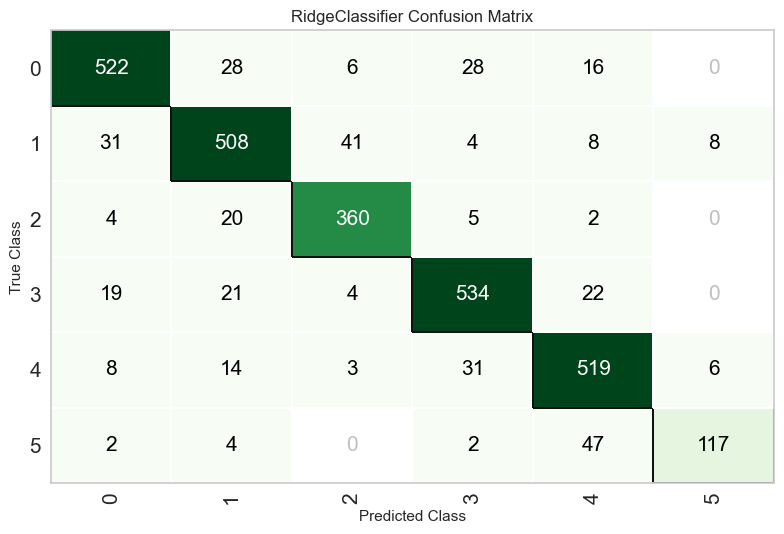

In [14]:
plot_model(best, plot = 'confusion_matrix')